In [63]:
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from evaluation.loader import ResultLoader as loader
from evaluation.single_prediction_eval import SinglePredictionEvaluator
from models.model_runner import get_all_model_names, load_test_set
loader = loader()

In [65]:
gt = load_dataset("json", data_files="test_data.json", split="train")

In [69]:
data = loader.load('1000_basic')

INFO:root:loading dataset from: results/1000_basic/cerebras-6b7_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-176b_original_1000.json


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/nya/.cache/huggingface/datasets/json/default-1100f5d0e69ecb86/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-3b_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-0b111_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-2b7_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-7b1_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-3b_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-0b111_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/gpt3.turbo-175b_paraphrased_1000.json


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/nya/.cache/huggingface/datasets/json/default-e8a752d9a46af393/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-1b7_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-7b1_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-6b7_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-1b7_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-2b7_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-1b1_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-176b_paraphrased_1000.json


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/nya/.cache/huggingface/datasets/json/default-f93a6a50ef453f4e/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-1b3_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-1b3_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/gpt3.turbo-175b_original_1000.json


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/nya/.cache/huggingface/datasets/json/default-c54703527b67c3b1/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-1b1_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

In [70]:
import Levenshtein
import re
def compute_precision_for_page(page):
    distance = Levenshtein.distance(page["prediction"], page["title"], score_cutoff=15)
    regex = "|".join(['.*(' + nameFragment + ').*' for nameFragment in page["title"].split()])
    if re.match(regex, page["prediction"]):
        return { "correct": 1, "prediction": page["prediction"], "title": page["title"], "distance": distance }
    else:
        return { "correct": 0, "prediction": page["prediction"], "title": page["title"], "distance": distance }

In [71]:
results = {}
# no_mask_page_ids = set()
no_mask_original = gt.filter(lambda x: '<mask>' not in x['masked_text_original'][:1000])
no_mask_paraphrased = gt.filter(lambda x: '<mask>' not in x['masked_text_paraphrased'][:1000])
no_mask_page_ids = set(no_mask_original['id'] + no_mask_paraphrased['id'])
for key, models in data.items():
    for model_name, model in models.items():
        for config in ['original', 'paraphrased']:
            dataset = model[config]['train']
            ## add ground truth label to each prediction
            mappable = dataset.add_column("title", gt["title"])
            # filter out examples which did not include a mask
            
            # compute precision
            computed = mappable.map(compute_precision_for_page, num_proc=4, remove_columns=mappable.column_names)
            # compute metrics over computed results
            correct_predictions = computed.filter(lambda x: x['correct'] == 1)
            incorrect_predictions = computed.filter(lambda x: x['correct'] == 0)
            correct = len(correct_predictions)
            model[config]["result"] = {}
            model[config]["result"]["data"] = computed
            model[config]["result"]["accuracy"] = correct / len(dataset)
            model[config]["result"]["correct_predictions"] = correct_predictions
            model[config]["result"]["incorrect_predictions"] = incorrect_predictions

#0:   0%|          | 0/2500 [00:00<?, ?ex/s]

#1:   0%|          | 0/2500 [00:00<?, ?ex/s]

#2:   0%|          | 0/2500 [00:00<?, ?ex/s]

#3:   0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

#0:   0%|          | 0/2500 [00:00<?, ?ex/s]

#1:   0%|          | 0/2500 [00:00<?, ?ex/s]

#2:   0%|          | 0/2500 [00:00<?, ?ex/s]

#3:   0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

#0:   0%|          | 0/2500 [00:00<?, ?ex/s]

#1:   0%|          | 0/2500 [00:00<?, ?ex/s]

#2:   0%|          | 0/2500 [00:00<?, ?ex/s]

#3:   0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

#0:   0%|          | 0/2500 [00:00<?, ?ex/s]

#1:   0%|          | 0/2500 [00:00<?, ?ex/s]

#2:   0%|          | 0/2500 [00:00<?, ?ex/s]

#3:   0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [73]:
data['gpt3.turbo']

{'175b': {'size': 175.0,
  'inputsize': '1000',
  'paraphrased': DatasetDict({
      train: Dataset({
          features: ['prediction', 'page_id', 'input_length'],
          num_rows: 10000
      })
      result: {'data': Dataset({
          features: ['prediction', 'title', 'correct', 'distance'],
          num_rows: 10000
      }), 'accuracy': 0.5198, 'correct_predictions': Dataset({
          features: ['prediction', 'title', 'correct', 'distance'],
          num_rows: 5198
      }), 'incorrect_predictions': Dataset({
          features: ['prediction', 'title', 'correct', 'distance'],
          num_rows: 4802
      })}
  }),
  'original': DatasetDict({
      train: Dataset({
          features: ['prediction', 'page_id', 'input_length'],
          num_rows: 10000
      })
      result: {'data': Dataset({
          features: ['prediction', 'title', 'correct', 'distance'],
          num_rows: 10000
      }), 'accuracy': 0.5972, 'correct_predictions': Dataset({
          features: ['pr

In [25]:
data

{'cerebras': {'6b7': {'size': 6.7,
   'inputsize': '1000',
   'original': DatasetDict({
       train: Dataset({
           features: ['prediction', 'page_id', 'input_length'],
           num_rows: 10000
       })
       result: {'data': Dataset({
           features: ['prediction', 'title', 'correct', 'distance'],
           num_rows: 10000
       }), 'accuracy': 0.0014, 'correct_predictions': Dataset({
           features: ['prediction', 'title', 'correct', 'distance'],
           num_rows: 14
       }), 'incorrect_predictions': Dataset({
           features: ['prediction', 'title', 'correct', 'distance'],
           num_rows: 9986
       })}
   }),
   'paraphrased': DatasetDict({
       train: Dataset({
           features: ['prediction', 'page_id', 'input_length'],
           num_rows: 10000
       })
       result: {'data': Dataset({
           features: ['prediction', 'title', 'correct', 'distance'],
           num_rows: 10000
       }), 'accuracy': 0.0002, 'correct_predictions': 

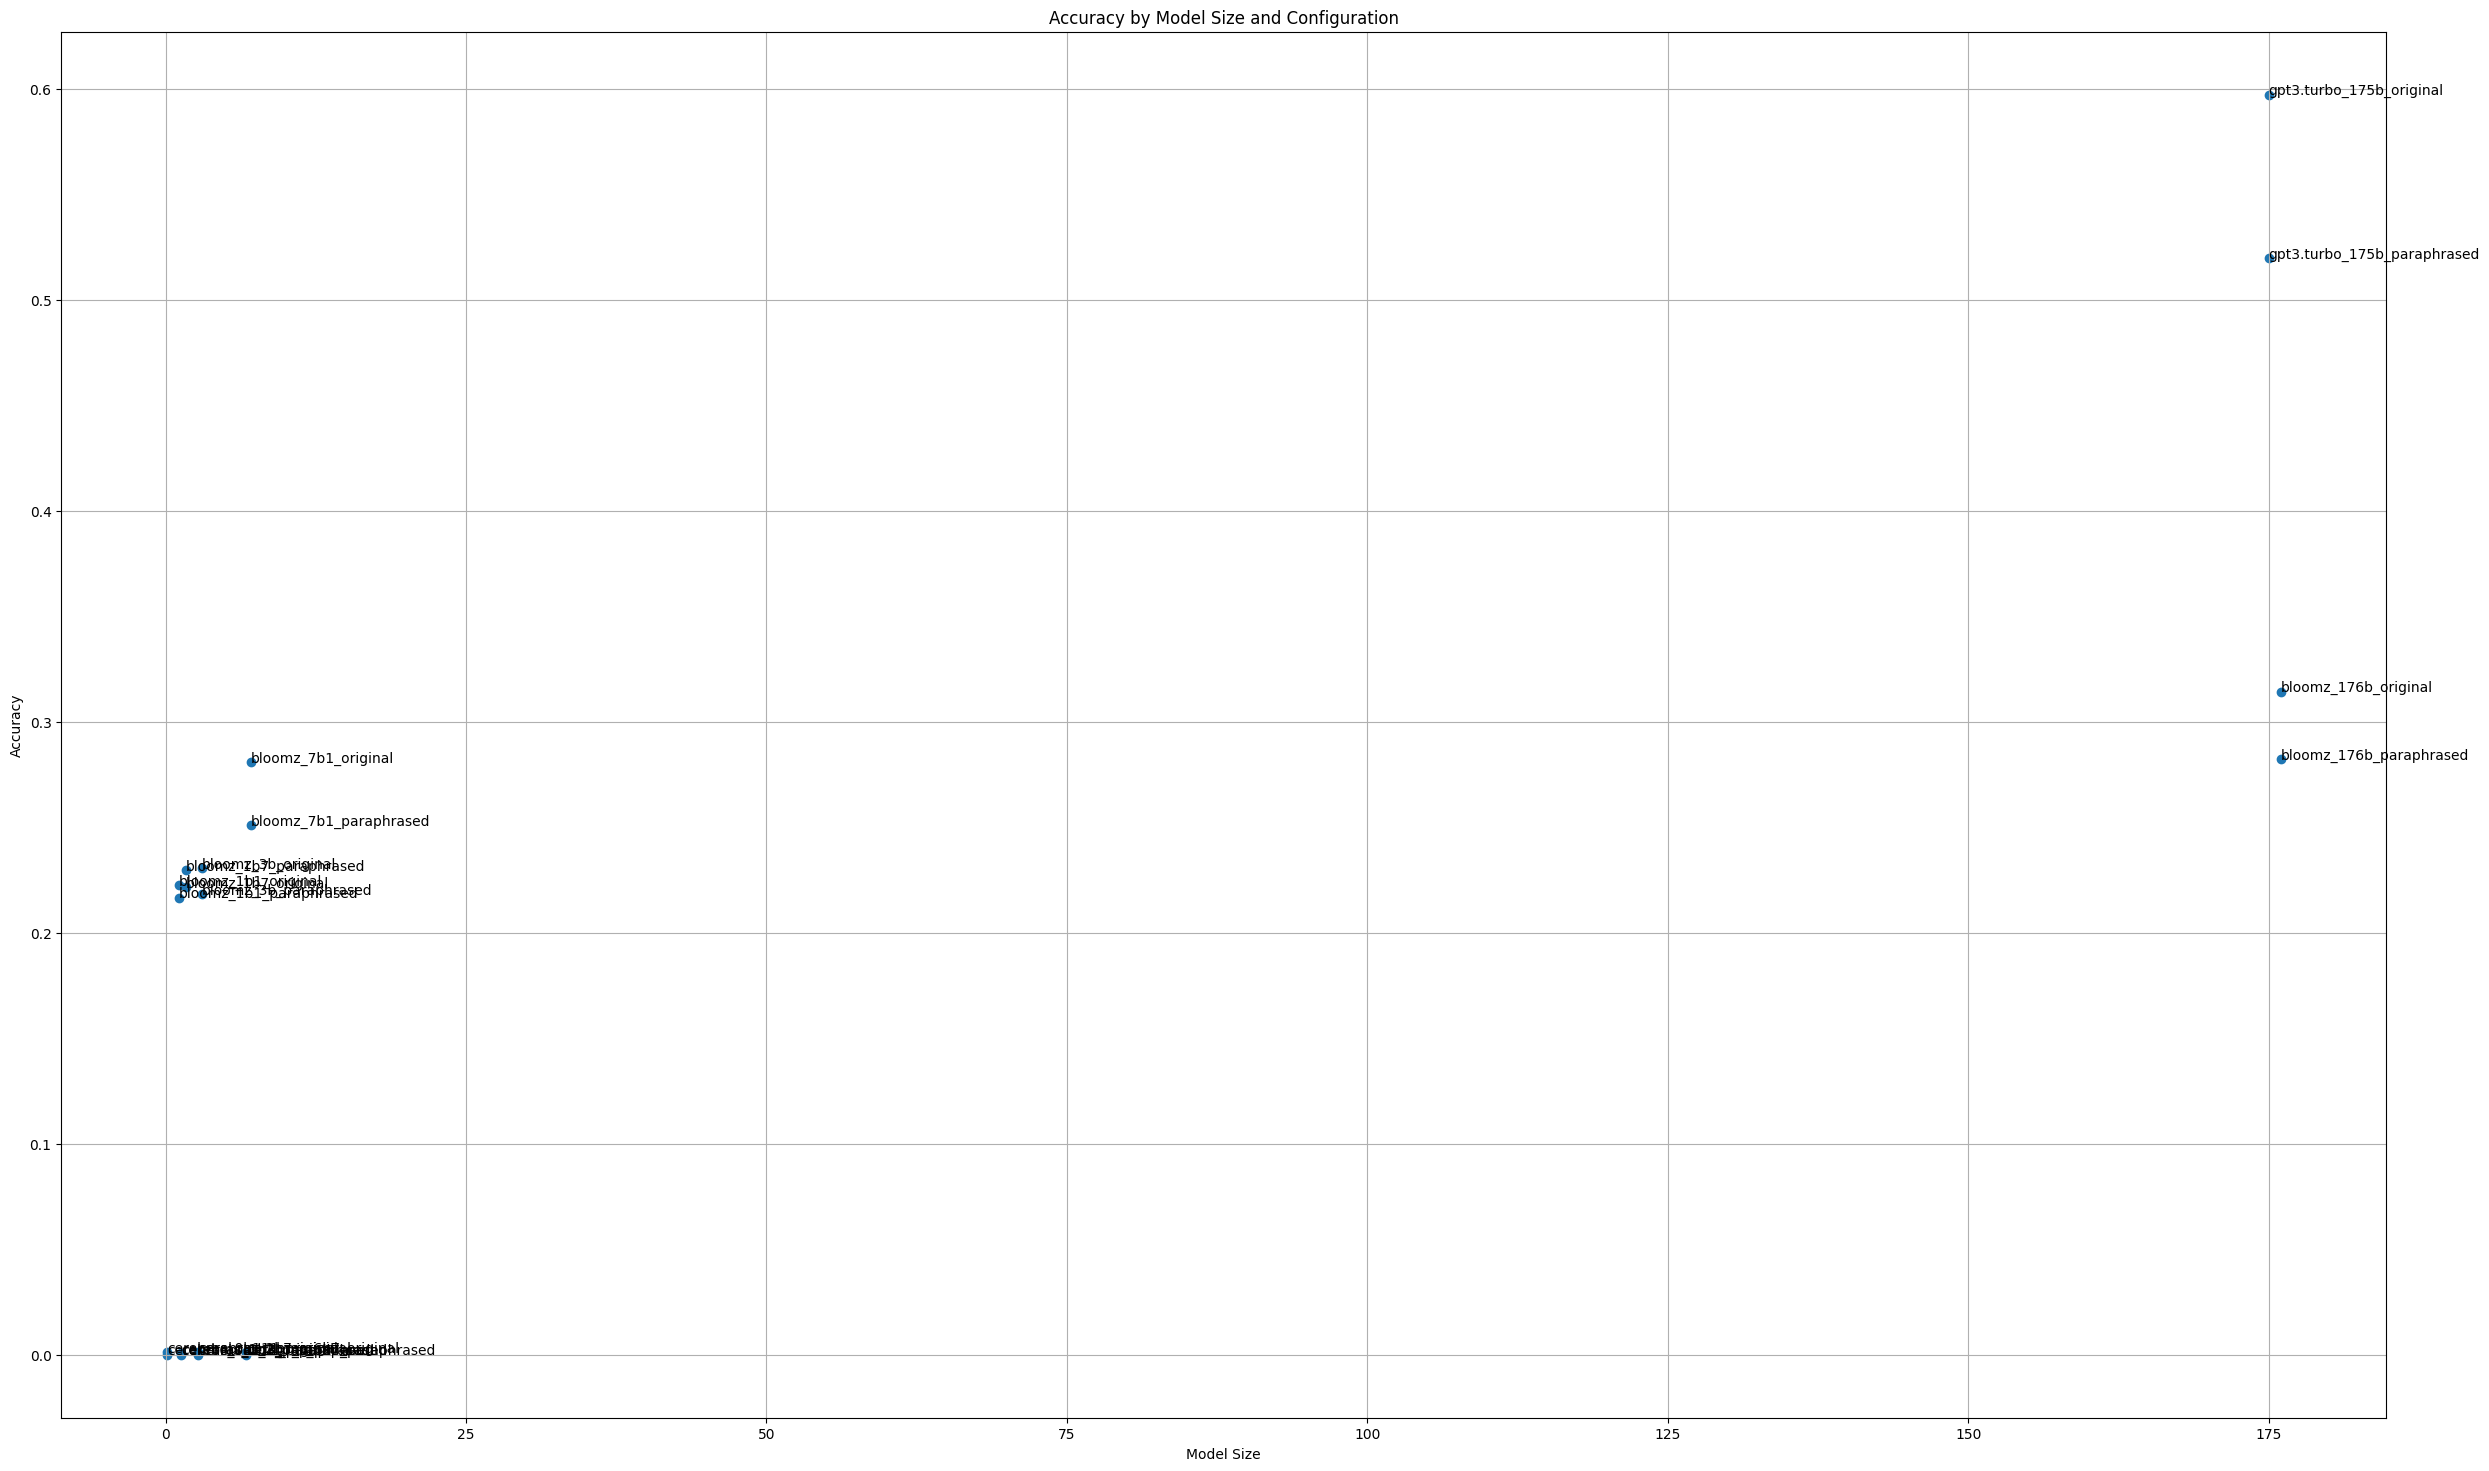

In [74]:
import matplotlib.pyplot as plt

# assuming your dataset is saved in a variable called 'data'
# data = {...}

sizes = []
accuracies = []
labels = []

for model, configs in data.items():
    for config, details in configs.items():
        for dataset, results in details.items():
            if isinstance(results, dict):  # check if result is a dictionary
                size = details['size']
                accuracy = results['result']['accuracy']
                
                sizes.append(size)
                accuracies.append(accuracy)
                labels.append(f"{model}_{config}_{dataset}")

plt.figure(figsize=(30, 18))
plt.scatter(sizes, accuracies)

for i, label in enumerate(labels):
    plt.annotate(label, (sizes[i], accuracies[i]))

plt.xlabel('Model Size')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model Size and Configuration')
plt.grid(True)
plt.show()

In [75]:
gt_df = pd.DataFrame(gt)
gt_df

,id,url,title,text,sentences,paraphrased_sentences,masked_text_original,masked_entities_original,masked_text_paraphrased,masked_entities_paraphrased
0,307,https://en.wikipedia.org/wiki/Abraham%20Lincoln,Abraham Lincoln,"Abraham Lincoln (; February 12, 1809 – April 1...","[Abraham Lincoln (; February 12, 1809 – April ...","[The 16th president of the United States, Abra...","<mask> (; February 12, 1809 – April 15, 1865) ...","[Abraham Lincoln, Lincoln, Lincoln, Lincoln, L...","The 16th president of the United States, <mask...","[Abraham Lincoln, Lincoln, Lincoln, Lincoln, L..."
1,404665,https://en.wikipedia.org/wiki/Austin%20Healey,Austin Healey,Austin Sean Healey (born 26 October 1973 in Wa...,[Austin Sean Healey (born 26 October 1973 in W...,[Austin Sean Healey is a former English rugby ...,<mask> (born 26 October 1973 in Wallasey (now ...,"[Austin Sean Healey, Austin, Healey, Healey, H...",<mask> is a former English rugby union player ...,"[Austin Sean Healey, Austin, Healey, Healey, H..."
2,28319266,https://en.wikipedia.org/wiki/Woody%20Abernath...,Woody Abernathy (outfielder),"Thomas Woodley ""Woody"" Abernathy (October 16, ...","[Thomas Woodley ""Woody"" Abernathy (October 16,...",[There was a professional baseball player name...,"Thomas Woodley ""<mask>"" <mask> (October 16, 19...","[Woody, Abernathy, Woody, Abernathy, Abernathy...",There was a professional baseball player named...,"[Woody, Abernathy, Woody, . Abernathy, Woody, ..."
3,1912218,https://en.wikipedia.org/wiki/Edie%20McClurg,Edie McClurg,"Edith Marie McClurg (born July 23, 1945) is an...","[Edith Marie McClurg (born July 23, 1945) is a...",[Edith Marie McClurg was born in 1945 and is a...,"<mask> (born July 23, 1945) is an American act...","[Edith Marie McClurg, McClurg, Irene McClurg, ...",<mask> was born in 1945 and is an American act...,"[Edith Marie McClurg, McClurg, McClurg, Edie, ..."
4,46646833,https://en.wikipedia.org/wiki/Suella%20Braverman,Suella Braverman,"Sue-Ellen Cassiana ""Suella"" Braverman (; born...","[Sue-Ellen Cassiana ""Suella"" Braverman (; bor...","[Sue-Ellen ""Suella"" Braverman is a British pol...","Sue-Ellen Cassiana ""<mask>"" <mask> (; born 3 ...","[Suella, Braverman, Braverman, Braverman, Brav...","Sue-Ellen ""<mask>"" <mask> is a British politic...","[Suella, Braverman, Braverman, Braverman, Brav..."
...,...,...,...,...,...,...,...,...,...,...
9995,27527437,https://en.wikipedia.org/wiki/Lojze%20Grozde,Lojze Grozde,Lojze Grozde (27 May 1923 – 1 January 1943) wa...,[Lojze Grozde (27 May 1923 – 1 January 1943) w...,[Lojze Grozde was murdered by Partisans during...,<mask> (27 May 1923 – 1 January 1943) was a Sl...,"[Lojze Grozde, Grozde, Lojze, Grozde, Lojze, G...",<mask> was murdered by Partisans during World ...,"[Lojze Grozde, Grozde, Lojze, Lojze, Grozde, L..."
9996,42853728,https://en.wikipedia.org/wiki/Howard%20Richard...,Howard Richards (academic),"Howard Richards (born June 10, 1938) is a phil...","[Howard Richards (born June 10, 1938) is a phi...",[Howard Richards is a philosopher who works wi...,"<mask> (born June 10, 1938) is a philosopher o...","[Howard Richards, Howard Richards, . Richards,...",<mask> is a philosopher who works with the con...,"[Howard Richards, Howard Richards, . Richards,..."
9997,7727513,https://en.wikipedia.org/wiki/Richard%20Hughes...,Richard Hughes (jockey),|}\n\n|}\nRichard Hughes (born 11 January 1973...,[|}\n\n|}\nRichard Hughes (born 11 January 197...,[Richard Hughes is a retired Irish jockey and ...,|}\n\n|}\n<mask> (born 11 January 1973) is a r...,"[Richard Hughes, Dessie Hughes, Hughes, Hughes...",<mask> is a retired Irish jockey and current r...,"[Richard Hughes, Dessie Hughes, Hughes, Hughes..."
9998,386522,https://en.wikipedia.org/wiki/Andr%C3%A9%20Bac...,André Bachand (Progressive Conservative MP),"André Bachand (born December 8, 1961) is a Can...","[André Bachand (born December 8, 1961) is a Ca...",[From 1997 to 2003 he was a member of the Prog...,"<mask> (born December 8, 1961) is a Can

In [141]:
# df = data['bloomz']['7b1']['original']['result']['data']
df = data['gpt3.turbo']['175b']['original']['result']['data']
# df = data['bloomz']['176b']['original']['result']['data']
df = df.to_pandas()
df

,prediction,title,correct,distance
0,Abraham Lincoln,Abraham Lincoln,1,0
1,Austin Healey,Austin Healey,1,0
2,Thomas Woodley Abernathy,Woody Abernathy (outfielder),1,16
3,Edie McClurg,Edie McClurg,1,0
4,Sue-Ellen Cassiana Braverman,Suella Braverman,1,12
...,...,...,...,...
9995,Grozde Korošec,Lojze Grozde,1,9
9996,David Schweickart,Howard Richards (academic),0,16
9997,Richard Hughes,Richard Hughes (jockey),1,9
9998,Noël A. Kinsella,André Bachand (Progressive Conservative MP),0,16


In [142]:
joined_df = pd.merge(df, gt_df, on='title')
joined_df

,prediction,title,correct,distance,id,url,text,sentences,paraphrased_sentences,masked_text_original,masked_entities_original,masked_text_paraphrased,masked_entities_paraphrased
0,Abraham Lincoln,Abraham Lincoln,1,0,307,https://en.wikipedia.org/wiki/Abraham%20Lincoln,"Abraham Lincoln (; February 12, 1809 – April 1...","[Abraham Lincoln (; February 12, 1809 – April ...","[The 16th president of the United States, Abra...","<mask> (; February 12, 1809 – April 15, 1865) ...","[Abraham Lincoln, Lincoln, Lincoln, Lincoln, L...","The 16th president of the United States, <mask...","[Abraham Lincoln, Lincoln, Lincoln, Lincoln, L..."
1,Austin Healey,Austin Healey,1,0,404665,https://en.wikipedia.org/wiki/Austin%20Healey,Austin Sean Healey (born 26 October 1973 in Wa...,[Austin Sean Healey (born 26 October 1973 in W...,[Austin Sean Healey is a former English rugby ...,<mask> (born 26 October 1973 in Wallasey (now ...,"[Austin Sean Healey, Austin, Healey, Healey, H...",<mask> is a former English rugby union player ...,"[Austin Sean Healey, Austin, Healey, Healey, H..."
2,Thomas Woodley Abernathy,Woody Abernathy (outfielder),1,16,28319266,https://en.wikipedia.org/wiki/Woody%20Abernath...,"Thomas Woodley ""Woody"" Abernathy (October 16, ...","[Thomas Woodley ""Woody"" Abernathy (October 16,...",[There was a professional baseball player name...,"Thomas Woodley ""<mask>"" <mask> (October 16, 19...","[Woody, Abernathy, Woody, Abernathy, Abernathy...",There was a professional baseball player named...,"[Woody, Abernathy, Woody, . Abernathy, Woody, ..."
3,Edie McClurg,Edie McClurg,1,0,1912218,https://en.wikipedia.org/wiki/Edie%20McClurg,"Edith Marie McClurg (born July 23, 1945) is an...","[Edith Marie McClurg (born July 23, 1945) is a...",[Edith Marie McClurg was born in 1945 and is a...,"<mask> (born July 23, 1945) is an American act...","[Edith Marie McClurg, McClurg, Irene McClurg, ...",<mask> was born in 1945 and is an American act...,"[Edith Marie McClurg, McClurg, McClurg, Edie, ..."
4,Sue-Ellen Cassiana Braverman,Suella Braverman,1,12,46646833,https://en.wikipedia.org/wiki/Suella%20Braverman,"Sue-Ellen Cassiana ""Suella"" Braverman (; born...","[Sue-Ellen Cassiana ""Suella"" Braverman (; bor...","[Sue-Ellen ""Suella"" Braverman is a British pol...","Sue-Ellen Cassiana ""<mask>"" <mask> (; born 3 ...","[Suella, Braverman, Braverman, Braverman, Brav...","Sue-Ellen ""<mask>"" <mask> is a British politic...","[Suella, Braverman, Braverman, Braverman, Brav..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Grozde Korošec,Lojze Grozde,1,9,27527437,https://en.wikipedia.org/wiki/Lojze%20Grozde,Lojze Grozde (27 May 1923 – 1 January 1943) wa...,[Lojze Grozde (27 May 1923 – 1 January 1943) w...,[Lojze Grozde was murdered by Partisans during...,<mask> (27 May 1923 – 1 January 1943) was a Sl...,"[Lojze Grozde, Grozde, Lojze, Grozde, Lojze, G...",<mask> was murdered by Partisans during World ...,"[Lojze Grozde, Grozde, Lojze, Lojze, Grozde, L..."
9996,David Schweickart,Howard Richards (academic),0,16,42853728,https://en.wikipedia.org/wiki/Howard%20Richard...,"Howard Richards (born June 10, 1938) is a phil...","[Howard Richards (born June 10, 1938) is a phi...",[Howard Richards is a philosopher who works wi...,"<mask> (born June 10, 1938) is a philosopher o...","[Howard Richards, Howard Richards, . Richards,...",<mask> is a philosopher who works with the con...,"[Howard Richards, Howard Richards, . Richards,..."
9997,Richard Hughes,Richard Hughes (jockey),1,9,7727513,https://en.wikipedia.org/wiki/Richard%20Hughes...,|}\n\n|}\nRichard Hughes (born 11 January 1973...,[|}\n\n|}\nRichard Hughes (born 11 January 197...,[Richard Hughes is a retired Irish jockey and ...,|}\n\n|}\n<mask> (born 11 January 1973) is a r...,"[Richard Hughes, Dessie Hughes, Hughes, Hughes...",<mask> is a retired Irish jockey and current r...,"[Richard Hughes, Dessie Hughes, Hughes, Hughes..."
9998,Noël A. Kinsella,André Bachand (Progressive Conservative MP),0,16,386522,ht

In [143]:
joined_df['text_length'] = joined_df['masked_text_original'].apply(len)
joined_df['mask_count'] = joined_df['masked_text_original'].apply(lambda x: x[:1000].count('<mask>'))

In [144]:
joined_df['text_length_group'] = pd.cut(joined_df['text_length'], range(0, 80001, 2000))
joined_df['mask_count_group'] = pd.cut(joined_df['mask_count'], range(0, 400, 1))

In [145]:
joined_df

,prediction,title,correct,distance,id,url,text,sentences,paraphrased_sentences,masked_text_original,masked_entities_original,masked_text_paraphrased,masked_entities_paraphrased,text_length,mask_count,text_length_group,mask_count_group
0,Abraham Lincoln,Abraham Lincoln,1,0,307,https://en.wikipedia.org/wiki/Abraham%20Lincoln,"Abraham Lincoln (; February 12, 1809 – April 1...","[Abraham Lincoln (; February 12, 1809 – April ...","[The 16th president of the United States, Abra...","<mask> (; February 12, 1809 – April 15, 1865) ...","[Abraham Lincoln, Lincoln, Lincoln, Lincoln, L...","The 16th president of the United States, <mask...","[Abraham Lincoln, Lincoln, Lincoln, Lincoln, L...",79908,4,"(78000, 80000]","(3, 4]"
1,Austin Healey,Austin Healey,1,0,404665,https://en.wikipedia.org/wiki/Austin%20Healey,Austin Sean Healey (born 26 October 1973 in Wa...,[Austin Sean Healey (born 26 October 1973 in W...,[Austin Sean Healey is a former English rugby ...,<mask> (born 26 October 1973 in Wallasey (now ...,"[Austin Sean Healey, Austin, Healey, Healey, H...",<mask> is a former English rugby union player ...,"[Austin Sean Healey, Austin, Healey, Healey, H...",7767,3,"(6000, 8000]","(2, 3]"
2,Thomas Woodley Abernathy,Woody Abernathy (outfielder),1,16,28319266,https://en.wikipedia.org/wiki/Woody%20Abernath...,"Thomas Woodley ""Woody"" Abernathy (October 16, ...","[Thomas Woodley ""Woody"" Abernathy (October 16,...",[There was a professional baseball player name...,"Thomas Woodley ""<mask>"" <mask> (October 16, 19...","[Woody, Abernathy, Woody, Abernathy, Abernathy...",There was a professional baseball player named...,"[Woody, Abernathy, Woody, . Abernathy, Woody, ...",10191,2,"(10000, 12000]","(1, 2]"
3,Edie McClurg,Edie McClurg,1,0,1912218,https://en.wikipedia.org/wiki/Edie%20McClurg,"Edith Marie McClurg (born July 23, 1945) is an...","[Edith Marie McClurg (born July 23, 1945) is a...",[Edith Marie McClurg was born in 1945 and is a...,"<mask> (born July 23, 1945) is an American act...","[Edith Marie McClurg, McClurg, Irene McClurg, ...",<mask> was born in 1945 and is an American act...,"[Edith Marie McClurg, McClurg, McClurg, Edie, ...",7212,1,"(6000, 8000]","(0, 1]"
4,Sue-Ellen Cassiana Braverman,Suella Braverman,1,12,46646833,https://en.wikipedia.org/wiki/Suella%20Braverman,"Sue-Ellen Cassiana ""Suella"" Braverman (; born...","[Sue-Ellen Cassiana ""Suella"" Braverman (; bor...","[Sue-Ellen ""Suella"" Braverman is a British pol...","Sue-Ellen Cassiana ""<mask>"" <mask> (; born 3 ...","[Suella, Braverman, Braverman, Braverman, Brav...","Sue-Ellen ""<mask>"" <mask> is a British politic...","[Suella, Braverman, Braverman, Braverman, Brav...",9387,3,"(8000, 10000]","(2, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Grozde Korošec,Lojze Grozde,1,9,27527437,https://en.wikipedia.org/wiki/Lojze%20Grozde,Lojze Grozde (27 May 1923 – 1 January 1943) wa...,[Lojze Grozde (27 May 1923 – 1 January 1943) w...,[Lojze Grozde was murdered by Partisans during...,<mask> (27 May 1923 – 1 January 1943) was a Sl...,"[Lojze Grozde, Grozde, Lojze, Grozde, Lojze, G...",<mask> was murdered by Partisans during World ...,"[Lojze Grozde, Grozde, Lojze, Lojze, Grozde, L...",10059,2,"(10000, 12000]","(1, 2]"
9996,David Schweickart,Howard Richards (academic),0,16,42853728,https://en.wikipedia.org/wiki/Howard%20Richard...,"Howard Richards (born June 10, 1938) is a phil...","[Howard Richards (born June 10, 1938) is a phi...",[Howard Richards is a philosopher who works wi...,"<mask> (born June 10, 1938) is a philosopher o...","[Howard Richards, Howard Richards, . Richards,...",<mask> is a philosopher who works with the con...,"[Howard Richards, Howard Richards, . Richards,...",14102,1,"(14000, 16000]","(0, 1]"
9997,Richard Hughes,Richard Hughes (jockey),1,9,7727513,https://en.wikipedia.org/wiki/Richard%20Hughes...,|}\n\n|}\nRichard Hughes (born 11 January 1973...,[|}\n\n|}\nRichard Hughes (born 11 January 197...,[Richard Hughes is a retired I

In [146]:
# grouped = joined_df.groupby(['text_length_group'])
grouped = joined_df.groupby(['mask_count_group'])
precision_df = grouped['correct'].mean().reset_index()

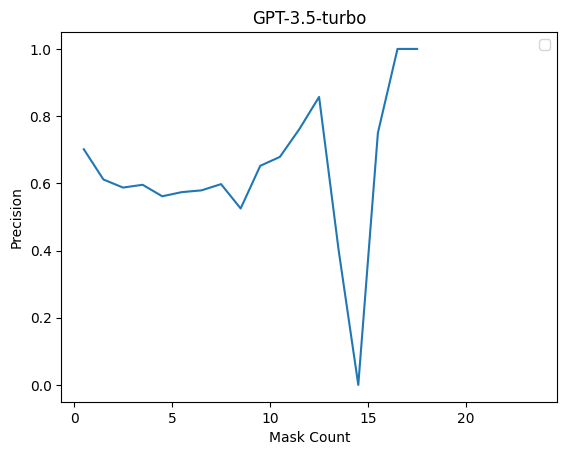

In [147]:
# models = precision_df['model'].unique()
import matplotlib.pyplot as plt
import seaborn as sns

# for model in models:
model_df = precision_df # precision_df[precision_df['model'] == model]
# plt.plot(model_df['text_length_group'].apply(lambda x: x.mid), model_df['correct']) #, label=model)
plt.plot(model_df['mask_count_group'].apply(lambda x: x.mid), model_df['correct']) #, label=model)

# plt.xlabel('Text Length')
plt.xlabel('Mask Count')
plt.ylabel('Precision')
# plt.title('Bloomz 176b')
plt.title('GPT-3.5-turbo')
plt.legend()
plt.show()


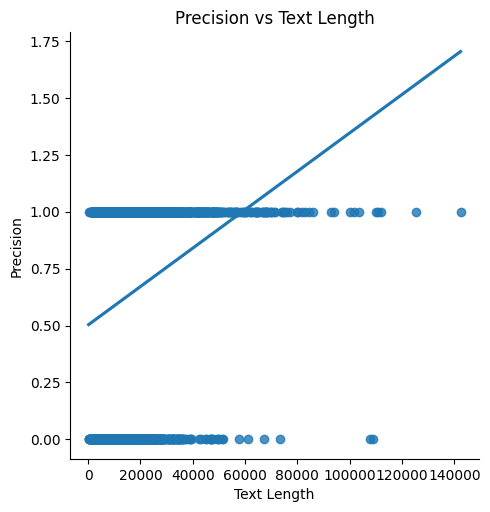

In [85]:
# Create a scatter plot with a regression line
sns.lmplot(x='text_length', y='correct', data=joined_df, ci=None)

# Set the plot title and labels
plt.title('Precision vs Text Length')
plt.xlabel('Text Length')
plt.ylabel('Precision')

# Show the plot
plt.show()


# accuracy vs size lineplot

In [3]:
bloomz_results = {
    "key": "run-all-top-5",
    "bloomz-3b": {
        "size": 3.0,
        "paraphrased": {
            "accuracy": 0.3028421052631579,
            "precision": 8.014598540145986
        },
        "original": {
            "accuracy": 0.30904699607527425,
            "precision": 7.644415499837186
        }
    },
    "bloomz-7b1": {
        "size": 7.1,
        "paraphrased": {
            "accuracy": 0.3509473684210526,
            "precision": 7.530893821235753
        },
        "original": {
            "accuracy": 0.37204387642145514,
            "precision": 7.204760616716256
        }
    },
    "bloomz-1b7": {
        "size": 1.7,
        "paraphrased": {
            "accuracy": 0.3201052631578947,
            "precision": 7.950016441959882
        },
        "original": {
            "accuracy": 0.3007950085538895,
            "precision": 7.7199732351957175
        }
    },
    "bloomz-1b1": {
        "size": 1.1,
        "paraphrased": {
            "accuracy": 0.3211578947368421,
            "precision": 7.8780727630285154
        },
        "original": {
            "accuracy": 0.33179027875616385,
            "precision": 7.630573248407643
        }
    }
}

In [2]:
data = {}
for model_name, model in bloomz_results.items():
    if model_name == "key":
        continue
    print(model_name)
    data[model_name] = {"size": model["size"]}


print(data)

bloomz-3b
bloomz-7b1
bloomz-1b7
bloomz-1b1
{'bloomz-3b': {'size': 3.0}, 'bloomz-7b1': {'size': 7.1}, 'bloomz-1b7': {'size': 1.7}, 'bloomz-1b1': {'size': 1.1}}


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

['bloomz-3b', 'bloomz-7b1', 'bloomz-1b7', 'bloomz-1b1']
[3.0, 7.1, 1.7, 1.1]
        model  size       config  accuracy
0   bloomz-3b   3.0  paraphrased  0.302842
1  bloomz-7b1   7.1  paraphrased  0.350947
2  bloomz-1b7   1.7  paraphrased  0.320105
3  bloomz-1b1   1.1  paraphrased  0.321158


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

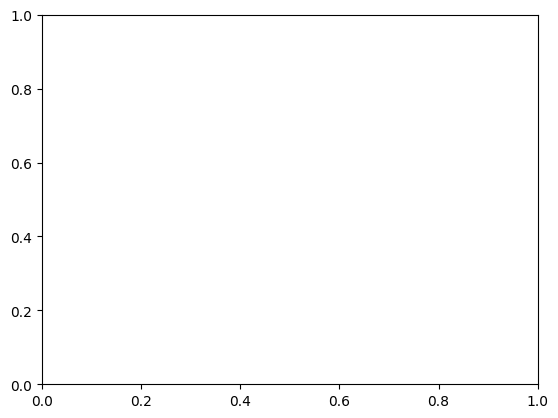

In [5]:
# Create empty lists to store the data
models = []
sizes = []
configs = []
accuracies = []

# Iterate over the dictionary and extract the data
for model, model_data in bloomz_results.items():
    # skip key
    if model == "key":
        continue
#     print(model)
#     print(model_data)
#     for config in ["original", "paraphrased"]
    accuracies.append(model_data['paraphrased']["accuracy"])
    sizes.append(model_data['size'])
    models.append(model)
    configs.append('paraphrased')

print(models)
print(sizes)
# # Create a DataFrame from the extracted data
df = pd.DataFrame({"model": models, "size": sizes, "config": configs, "accuracy": accuracies})

print(df)
# Plot using Seaborn
# hue="config", style="config"
sns.lineplot(data=df, x="size", y="accuracy", markers=True, label="whatever")

# Set labels and title
plt.xlabel("Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Size")

# Show the plot
plt.show()

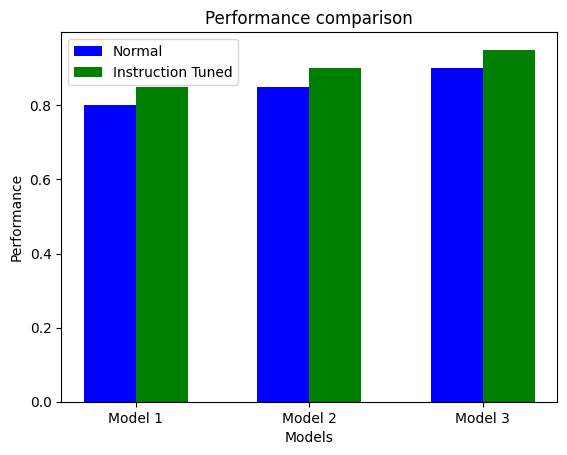

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you have the following data:
models = ['Model 1', 'Model 2', 'Model 3']
normal_performance = [0.8, 0.85, 0.9]  # Replace with your actual performance metrics
instruction_performance = [0.85, 0.9, 0.95]  # Replace with your actual performance metrics

# Calculate the width of a bar
bar_width = 0.3

# Positions of the left bar boundaries
bar_l = np.arange(len(models))

# Positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i + bar_width / 2 for i in bar_l]

# Create the bar plot
plt.bar(bar_l, normal_performance, width=bar_width, label='Normal', color='b')
plt.bar(bar_l + bar_width, instruction_performance, width=bar_width, label='Instruction Tuned', color='g')

# Set the labels and title
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Performance comparison')

# Set the positions and labels of the x-axis ticks
plt.xticks(tick_pos, models)

# Adding the legend and showing the plot
plt.legend()
plt.show()


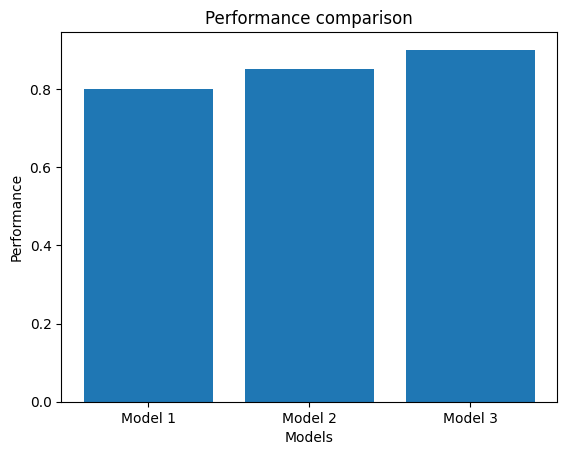

In [1]:
import matplotlib.pyplot as plt

# Suppose you have the following data:
models = ['Model 1', 'Model 2', 'Model 3']
performance = [0.8, 0.85, 0.9]  # Just an example, replace with your actual performance metrics

# Create a bar plot
plt.bar(models, performance)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Performance comparison')

# Show the plot
plt.show()


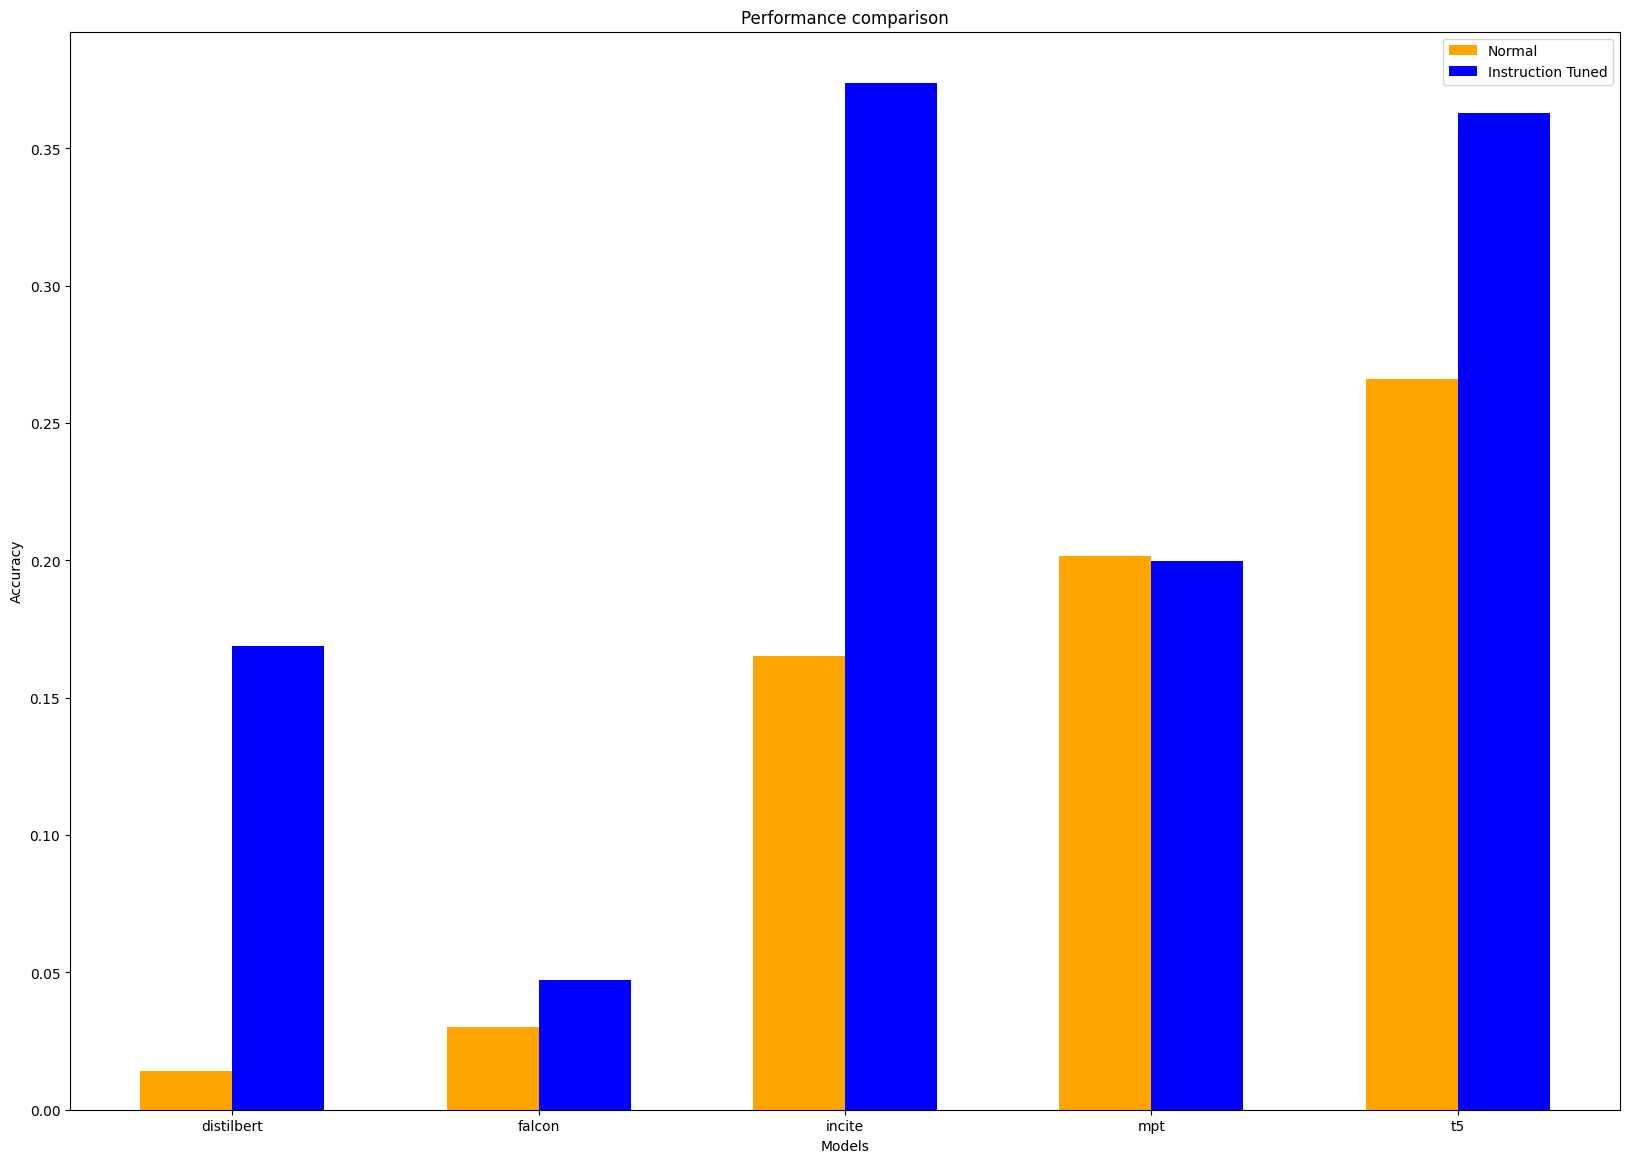

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))

# Create DataFrame
data = {
    'model': ['t5-3b', 'flan_t5-3b', 'distilbert-0b066', 'distilbert_squad-0b062', 'falcon_instruct-7b', 'falcon-7b', 'mpt-7b', 'mpt_instruct-6b7', 'incite_instruct-3b', 'incite-3b'],
    'model_class': ['t5', 'flan_t5', 'distilbert', 'distilbert_squad', 'falcon_instruct', 'falcon', 'mpt', 'mpt_instruct', 'incite_instruct', 'incite'],
    'size': [3.000, 3.000, 0.066, 0.062, 7.000, 7.000, 7.000, 6.700, 3.000, 3.000],
    'accuracy': [0.266000, 0.363053, 0.014000, 0.168842, 0.047053, 0.030000, 0.201474, 0.199895, 0.373789, 0.165158],
}
df = pd.DataFrame(data)

# Add 'is_instructional' column
df["is_instructional"] = df["model_class"].apply(
    lambda x: "instruction tuned" if ("squad" in x or "flan" in x or "instruct" in x) else "normal")

# Define models
models = ["falcon", "roberta", "distilbert", "mpt", "incite", "t5"]

# Group by model names
df['model_name'] = df["model"].str.extract(f"({'|'.join(models)})")[0]
grouped = df.groupby(['model_name', 'is_instructional'])

# Prepare data for plot
plot_data = []
for name, group in grouped:
    plot_data.append((name[0], name[1], group['accuracy'].mean()))

# Sort data by model name
plot_data.sort()

# Split data into separate lists
names, types, accuracies = zip(*plot_data)
unique_names = sorted(set(names))
normal_accuracies = [accuracy for name, type_, accuracy in plot_data if type_ == 'normal']
instruction_accuracies = [accuracy for name, type_, accuracy in plot_data if type_ == 'instruction tuned']

# Calculate the width of a bar
bar_width = 0.3

# Positions of the left bar boundaries
bar_l = np.arange(len(unique_names))

# Positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i + bar_width / 2 for i in bar_l]

# Create the bar plot
plt.bar(bar_l, normal_accuracies, width=bar_width, label='Normal', color='orange')
plt.bar(bar_l + bar_width, instruction_accuracies, width=bar_width, label='Instruction Tuned', color='blue')

# Set the labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Performance comparison')

# Set the positions and labels of the x-axis ticks
plt.xticks(tick_pos, unique_names)

# Adding the legend and showing the plot
plt.legend()
plt.show()
